# The task is to create DL model to distinguish photos of hot-dogs from photos of not hot-dogs. The task has been performed for the in-class Kaggle competition. 

## Importing libraries and data preparation

In [1]:
#import libraries
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input
from keras.optimizers import Nadam

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
#import libraries
import os

import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from matplotlib.image import imread
%matplotlib inline

In [3]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!ls '/content/drive/MyDrive'

In [7]:
#fix directories for train and test data
SEED = 257

TRAIN_DIR = '/content/drive/MyDrive/hot_dog/train/'
TEST_DIR = '/content/drive/MyDrive/hot_dog/test/'

In [8]:
#define categories
categories = ['hot dog', 'not hot dog']

In [9]:
#create a dataset
X, y = [], []

for category in categories:
    category_dir = os.path.join(TRAIN_DIR, category)
    for image_path in os.listdir(category_dir):
        X.append(imread(os.path.join(category_dir, image_path)))
        y.append(category)

In [10]:
len(X), len(y)

(10049, 10049)

In [11]:
X[0].shape

(100, 100, 3)

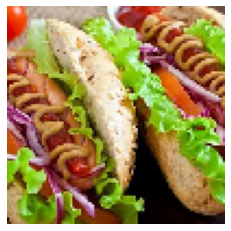

In [14]:
plt.axis("off");
plt.imshow(X[1000]);

## Train-test split

In [15]:
#define the response
y = [1 if x == 'hot dog' else 0 for x in y]

In [18]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.25, random_state=SEED, stratify = y)

In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7536, 100, 100, 3), (2513, 100, 100, 3), (7536,), (2513,))

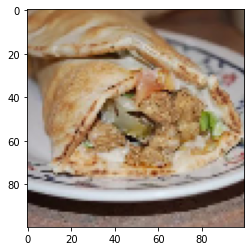

In [20]:
plt.imshow(X_train[7535]);

## Data preparation and transfer to matrix representation

In [39]:
img_rows = 100
img_cols = 100
num_classes = 2

In [40]:
#check format of image
K.image_data_format()

'channels_last'

In [41]:
if K.image_data_format() == 'channels_first':
    x_train = X_train.reshape(X_train.shape[0], 3, img_rows, img_cols)
    x_test = X_test.reshape(X_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    x_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

In [ ]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [52]:
#transfer to the matrix representation
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [53]:
y_train = y_train.reshape((-1,2))

# transfer learning

In [21]:
#import additional libraries and basic model
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.models import model_from_json
from keras.optimizers import Nadam
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import MaxPooling2D
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

In [42]:
#apply data augmentation
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [43]:
#datagen.fit(x_train)

In [55]:
#define an architecture of a neural network, applying transfer learning
base_model = Xception(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(200,activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(170,activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

In [56]:
model2 = Model(inputs=base_model.input, outputs=predictions)


In [57]:
#fix weights of a base model
for layer in base_model.layers:
    layer.trainable = False

In [58]:
 #fix metrics and loss function
model2.compile(optimizer=Nadam(learning_rate=0.0001), 
loss='binary_crossentropy',metrics=[tf.keras.metrics.AUC()])

In [59]:
x_test[500].shape

(100, 100, 3)

In [60]:
y_test[500].shape

(2,)

In [61]:
#fit the model
model2.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
          steps_per_epoch=len(x_train)/32, epochs=3,
          verbose=1, validation_data=(x_test, y_test))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
235/235 [==============================] - 382s 2s/step - loss: 0.3757 - auc_3: 0.8705 - val_loss: 0.2116 - val_auc_3: 0.9437
Epoch 2/3
235/235 [==============================] - 357s 2s/step - loss: 0.2660 - auc_3: 0.9487 - val_loss: 0.1944 - val_auc_3: 0.9541
Epoch 3/3
235/235 [==============================] - 365s 2s/step - loss: 0.2236 - auc_3: 0.9564 - val_loss: 0.1876 - val_auc_3: 0.9588


In [62]:
#calculate metrics for validation dataset
roc_auc_score(y_test, model2.predict(x_test))

0.9309943615372966

# predictions 

In [63]:
leaderboard_X = []
leaderboard_filenames = []

In [64]:
#create a test dataset
for image_path in os.listdir(TEST_DIR):
    leaderboard_X.append(imread(os.path.join(TEST_DIR, image_path)))
    leaderboard_filenames.append(image_path)

In [65]:
print(leaderboard_X[0].shape, leaderboard_filenames[0])

(100, 100, 3) 0003a33387289b715622ad0c3e2b5e8ba075269ad61c80b76185e40b7e33bf1c.png


In [66]:
X_test_t = np.array(leaderboard_X)

In [67]:
#calculate predictions
leaderboard_predictions = model2.predict(X_test_t)[:,1]



In [68]:
leaderboard_predictions = leaderboard_predictions.tolist()

In [69]:
font = {
    'family': 'serif',
    'color':  'darkred',
    'weight': 'bold',
    'size': 22,
}

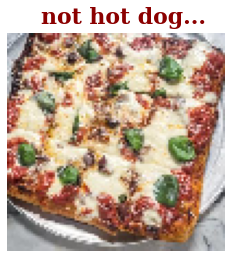

In [70]:
idx = 15

plt.axis("off");
if leaderboard_predictions[idx] > 0.5:
    plt.text(20, -5, 'HOT DOG!!!', fontdict=font)
else:
    plt.text(15, -5,'not hot dog...', fontdict=font)
plt.imshow(leaderboard_X[idx]);

In [71]:
#create a submission
submission = pd.DataFrame(
    {
        'image_id': leaderboard_filenames, 
        'image_hot_dog_probability': leaderboard_predictions}
)

In [72]:
submission.to_csv(path_or_buf='submission_hotdogs5.csv', index=False)

In [73]:
submission.head()

,image_id,image_hot_dog_probability
0,0003a33387289b715622ad0c3e2b5e8ba075269ad61c80...,0.000002
1,00b09fd8b88e08d1e3d7ea2d7448b2366a8b41ab20c8e3...,0.000029
2,00b453c09e2717e384ed28a586517cb255c44b19163cac...,0.001421
3,00ba309472441da7bac277dbc8e96ca2ddc0dcd50844e4...,0.001931
4,00c5e0f2f1898a6fd931d83eb4d0383ef702a9e8f62bb2...,0.000019
